In [1]:
import time
import matplotlib.pyplot as plt
import torch

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 8
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 128

blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([8, 65536, 3]),
 torch.Size([8, 65536, 3]),
 torch.Size([8, 130050, 3]))

In [14]:
import os
import torch 
import torch.nn.functional as F 

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as T3

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    RasterizationSettings,
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
)


class MeshPointsRenderer(torch.nn.Module):
    def __init__(self, opt):    
        super(MeshPointsRenderer, self).__init__()
        self.opt = opt
        self.max_brightness = opt.raster_max_brightness        
        trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.data_patch_size)))        
        self.register_buffer('faces',  trimap['faces'])
        self.register_buffer('vert_tri_indices', trimap['vert_tri_indices'])
        self.register_buffer('vert_tri_weights', trimap['vert_tri_weights'])
        self.renderer = None
    
    def setup(self, device):
        if  self.renderer is not None: return              
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = RasterizationSettings(
            image_size= self.opt.raster_image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1,
        )
        rasterizer= MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )        
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        blend_params = BlendParams(background_color= (0.0, 0.0, 0.0),)
        shader = SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights,
            blend_params=blend_params,
        )        
        self.renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader
        )                
        
    
    def get_face_normals(self, vrt):
        faces = self.faces
        v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
        v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
        face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
        return face_normals

    def get_vertex_normals(self, vrt):
        face_normals = self.get_face_normals(vrt)
        bs = face_normals.size(0)
        r, c = self.vert_tri_indices.shape
        fn_group = face_normals.index_select(1, 
            self.vert_tri_indices.flatten()).reshape(bs, r, c, 3)
        weighted_fn_group = fn_group * self.vert_tri_weights    
        vertex_normals = weighted_fn_group.sum(dim=-2)
        return F.normalize(vertex_normals, p=2, dim=-1)

    
    def __call__(self, verts, faces):
        assert len(verts.shape) == 3 and verts.shape[-1] == 3
        bs = verts.size(0)
        verts_rgb = torch.ones_like(verts)
        textures = TexturesVertex(verts_features=verts_rgb)        
        mesh = Meshes(verts=verts, 
                      faces=faces,
                      textures=textures)
        return self.renderer(mesh)

M = MeshPointsRenderer(config)    
M.setup(device)

R = PointsRenderer(config)
R.setup(device)

0.03169846534729004


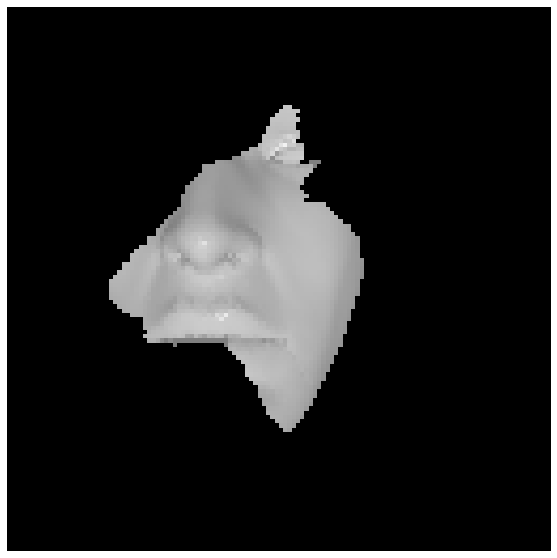

In [18]:
start_time = time.time()
images = R(points, normals=normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [9]:
points.device, faces.device

(device(type='cuda', index=0), device(type='cuda', index=0))

0.08612370491027832


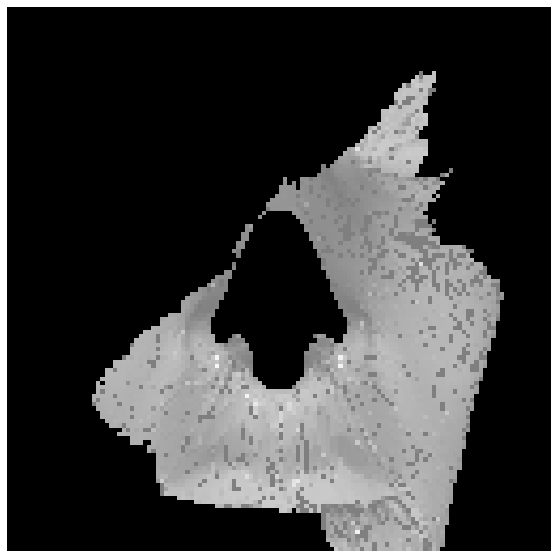

In [17]:
start_time = time.time()
images = M(points, faces)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [ ]:
P = PulsarRenderer(config)
P.setup(device)

0.03096461296081543


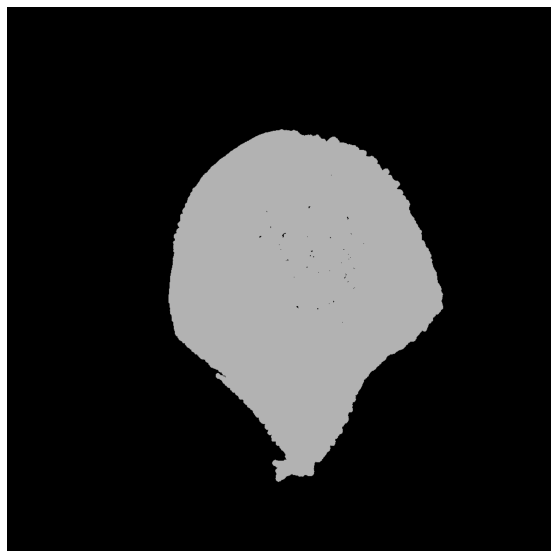

In [42]:
start_time = time.time()
images = P(points)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [27]:
config.data_patch_size,  config.raster_image_size

(256, 128)

In [19]:
opt = config

R, T = look_at_view_transform(
    opt.viewpoint_distance, 
    opt.viewpoint_elevation, 
    opt.viewpoint_azimuth, 
    device=device)
cameras = FoVPerspectiveCameras(
    device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size= opt.raster_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1,
)
rasterizer= MeshRasterizer(
    cameras=cameras, 
    raster_settings=raster_settings
)        
lights = PointLights(device=device, 
                     location=[opt.lights_location])
shader = SoftPhongShader(
    device=device, 
    cameras=cameras,
    lights=lights
)        
self.renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=shader
)     

TypeError: __init__() got an unexpected keyword argument 'rasterizer'